In [1]:
# Шаг 1: Подготовка датасета
# В Google Colab для скачивания с Kaggle
!pip install kaggle
!mkdir -p ~/.kaggle

# Загрузите свой kaggle.json (нужен аккаунт Kaggle)
from google.colab import files
files.upload()  # Загрузите kaggle.json

!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Скачиваем датасет
!kaggle datasets download -d aaronschlegel/austin-animal-center-shelter-intakes-and-outcomes
!unzip austin-animal-center-shelter-intakes-and-outcomes.zip

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/aaronschlegel/austin-animal-center-shelter-intakes-and-outcomes
License(s): ODbL-1.0
  0% 0.00/9.25M [00:00<?, ?B/s]
100% 9.25M/9.25M [00:00<00:00, 1.05GB/s]
Archive:  austin-animal-center-shelter-intakes-and-outcomes.zip
  inflating: aac_intakes.csv         
  inflating: aac_intakes_outcomes.csv  
  inflating: aac_outcomes.csv        


In [2]:
# Шаг 2: # Создаем папку data и перемещаем файлы
!mkdir -p data
!mv aac_intakes.csv data/
!mv aac_outcomes.csv data/
!mv aac_intakes_outcomes.csv data/

# Проверяем
!ls -la data/


total 54828
drwxr-xr-x 2 root root     4096 Sep 27 06:29 .
drwxr-xr-x 1 root root     4096 Sep 27 06:29 ..
-rw-r--r-- 1 root root 13040169 Sep 29  2019 aac_intakes.csv
-rw-r--r-- 1 root root 31441583 Sep 29  2019 aac_intakes_outcomes.csv
-rw-r--r-- 1 root root 11648624 Sep 29  2019 aac_outcomes.csv


In [ ]:
# Шаг 3: Создание файлов проекта

In [3]:
%%writefile requirements.txt
Numpy==2.3.3
pandas==2.3.2
matplotlib==3.10.6
seaborn==0.12.2

Writing requirements.txt


In [4]:
%%writefile database.py
import sqlite3
import pandas as pd
import os

def delete_existing_database():
    """Удаление существующей базы данных, если она есть"""
    print("Проверяем существующую базу данных...")
    if os.path.exists('animal_shelter.db'):
        os.remove('animal_shelter.db')
        print("Существующая база данных удалена")
    else:
        print("База данных не существует, создаем новую")

def print_table_sample(conn, table_name, limit=20):
    """Вывод sample данных из таблицы"""
    print(f"\nСодержимое таблицы {table_name} (первые {limit} записей):")
    print("-" * 60)
    try:
        query = f"SELECT * FROM {table_name} LIMIT {limit}"
        df = pd.read_sql_query(query, conn)
        if len(df) > 0:
            print(df.to_string(index=False))
            print(f"Всего записей в таблице: {pd.read_sql_query(f'SELECT COUNT(*) FROM {table_name}', conn).iloc[0,0]}")
        else:
            print("Таблица пуста")
    except Exception as e:
        print(f"Ошибка при чтении таблицы {table_name}: {e}")

def print_view_sample(conn, view_name, limit=20):
    """Вывод sample данных из view"""
    print(f"\nСодержимое view {view_name} (первые {limit} записей):")
    print("-" * 60)
    try:
        query = f"SELECT * FROM {view_name} LIMIT {limit}"
        df = pd.read_sql_query(query, conn)
        if len(df) > 0:
            print(df.to_string(index=False))
            print(f"Всего записей в представлении {view_name}: {pd.read_sql_query(f'SELECT COUNT(*) FROM {view_name}', conn).iloc[0,0]}")
        else:
            print("Представление пустое")
    except Exception as e:
        print(f"Ошибка при чтении view {view_name}: {e}")

def create_raw_tables():
    """Создание сырых таблиц - копий CSV файлов"""
    print("\nЗагружаем CSV файлы в сырые таблицы...")

    conn = sqlite3.connect('animal_shelter.db')

    try:
        # Загрузка данных в сырые таблицы
        print("Загружаем aac_intakes.csv...")
        intake_df = pd.read_csv('data/aac_intakes.csv')
        print("Загружаем aac_outcomes.csv...")
        outcome_df = pd.read_csv('data/aac_outcomes.csv')

        # Создаем сырые таблицы
        print("Сохраняем raw_intake...")
        intake_df.to_sql('raw_intake', conn, if_exists='replace', index=False)
        print("Сохраняем raw_outcome...")
        outcome_df.to_sql('raw_outcome', conn, if_exists='replace', index=False)

        print("Сырые таблицы созданы успешно")
        print()

        print_table_sample(conn, 'raw_intake')
        print_table_sample(conn, 'raw_outcome')

    except Exception as e:
        print(f"Ошибка при создании сырых таблиц: {e}")
        raise
    finally:
        conn.close()

def create_temp_views():
    """Создание временных представлений для анализа"""
    print("\nСоздаем временные представления для анализа...")

    conn = sqlite3.connect('animal_shelter.db')
    cursor = conn.cursor()

    try:
        # Временное представление для уникальных животных
        print("Создаем представление unique_animals...")
        print("Выбираем уникальные animal_id из raw_intake и raw_outcome и к ним присоединяем данные о name, animal_type, breed, color из raw_outcome, если есть, иначе - из raw_intake")
        cursor.execute('''
        CREATE VIEW IF NOT EXISTS unique_animals AS
        SELECT
            intake.animal_id,
            COALESCE(out.name, intake.name) AS name,
            COALESCE(out.animal_type, intake.animal_type) AS animal_type,
            COALESCE(out.breed, intake.breed) AS breed,
            COALESCE(out.color, intake.color) AS color
        FROM
            raw_intake intake
        LEFT JOIN
            raw_outcome out ON intake.animal_id = out.animal_id
        UNION
        SELECT
            out.animal_id,
            out.name,
            out.animal_type,
            out.breed,
            out.color
        FROM
            raw_outcome out
        LEFT JOIN
            raw_intake intake ON out.animal_id = intake.animal_id
        WHERE
            intake.animal_id IS NULL
        ''')

        conn.commit()
        print("Временное представленияе создано успешно")

        print()
        print_view_sample(conn, 'unique_animals')

    except Exception as e:
        print(f"Ошибка при создании временных представлений: {e}")
        raise
    finally:
        conn.close()

def analyze_raw_data():
    """Анализ сырых данных перед обработкой"""
    print("\nАнализируем данные в представлениях")

    conn = sqlite3.connect('animal_shelter.db')

    try:
        print("\nПроверяем, что у нас не размножились записи при формировании unique_animals")
        unique_animal_id = pd.read_sql_query('WITH s1 as (SELECT animal_id FROM raw_outcome UNION SELECT animal_id FROM raw_intake) SELECT count(animal_id) from s1', conn).iloc[0,0]
        unique_animals_records_count = pd.read_sql_query(f'SELECT COUNT(*) FROM unique_animals', conn).iloc[0,0]
        if unique_animal_id == unique_animals_records_count:
            print("Всего уникальных animal_id в raw_intake и raw_outcome:", unique_animal_id, "что равно количеству записей в unique_animals")
        else:
            ("Что-то пошло не так. Всего уникальных animal_id в raw_intake и raw_outcome: ", unique_animal_id, "что не равно количеству записей в unique_animals")

        print("\nМожно сделать еще много разных представлений и запросов, но в DBeaver это делать удобнее\n")


    except Exception as e:
        print(f"Ошибка при анализе данных: {e}")
        raise
    finally:
        conn.close()

def create_normalized_tables():
    """Создание нормализованных таблиц со справочниками"""
    print("\nСоздаем нормализованную структуру...")

    conn = sqlite3.connect('animal_shelter.db')
    cursor = conn.cursor()

    try:
        # 1. Создаем справочник типов животных
        print("Создаем сравочник animal_types...")
        cursor.execute('''
        CREATE TABLE animal_types (
            type_id INTEGER PRIMARY KEY AUTOINCREMENT,
            animal_type TEXT UNIQUE NOT NULL
        )
        ''')

        cursor.execute('''
        INSERT OR IGNORE INTO animal_types (animal_type)
        SELECT DISTINCT animal_type FROM (
            SELECT animal_type FROM raw_intake
            UNION
            SELECT animal_type FROM raw_outcome
        )
        ''')
        print(f"   Добавлено записей: {cursor.rowcount}")

        # 2. Создаем справочник окрасов
        print("Создаем справочник colors...")
        cursor.execute('''
        CREATE TABLE colors (
            color_id INTEGER PRIMARY KEY AUTOINCREMENT,
            color_name TEXT UNIQUE NOT NULL
        )
        ''')

        cursor.execute('''
        INSERT OR IGNORE INTO colors (color_name)
        SELECT DISTINCT color FROM (
            SELECT color FROM raw_intake
            UNION
            SELECT color FROM raw_outcome
        )
        ''')
        print(f"   Добавлено записей: {cursor.rowcount}")

        # 3. Создаем справочник пород
        print("Создаем справочник breeds...")
        cursor.execute('''
        CREATE TABLE breeds (
            breed_id INTEGER PRIMARY KEY AUTOINCREMENT,
            breed_name TEXT UNIQUE NOT NULL
        )
        ''')

        cursor.execute('''
        INSERT OR IGNORE INTO breeds (breed_name)
        SELECT DISTINCT breed FROM (
            SELECT breed FROM raw_intake
            UNION
            SELECT breed FROM raw_outcome
        )
        ''')
        print(f"   Добавлено записей: {cursor.rowcount}")

        # 4. Создаем основную таблицу животных
        print("Создаем таблицу animals...")
        cursor.execute('''
        CREATE TABLE animals (
            animal_id TEXT PRIMARY KEY,
            name TEXT,
            animal_type_id INTEGER,
            breed_id INTEGER,
            color_id INTEGER,
            FOREIGN KEY (animal_type_id) REFERENCES animal_types(type_id),
            FOREIGN KEY (breed_id) REFERENCES breeds(breed_id),
            FOREIGN KEY (color_id) REFERENCES colors(color_id)
        )
        ''')

        # Заполняем таблицу животных
        print("Заполняем таблицу animals...")
        cursor.execute('''
        INSERT OR REPLACE INTO animals (animal_id, name, animal_type_id, breed_id, color_id)
        SELECT
            ua.animal_id,
            ua.name,
            at.type_id,
            b.breed_id,
            c.color_id
        FROM unique_animals ua
        JOIN animal_types at ON ua.animal_type = at.animal_type
        JOIN breeds b ON ua.breed = b.breed_name
        JOIN colors c ON ua.color = c.color_name
        ''')
        print(f"   Добавлено животных: {cursor.rowcount}")

        # 5. Создаем таблицу поступлений
        print("Создаем таблицу intake...")
        cursor.execute('''
        CREATE TABLE intake (
            intake_id INTEGER PRIMARY KEY AUTOINCREMENT,
            animal_id TEXT,
            intake_date TEXT NOT NULL,
            intake_type TEXT,
            intake_condition TEXT,
            found_location TEXT,
            FOREIGN KEY (animal_id) REFERENCES animals(animal_id)
        )
        ''')

        cursor.execute('''
        INSERT INTO intake (animal_id, intake_date, intake_type, intake_condition, found_location)
        SELECT
            animal_id,
            datetime,
            intake_type,
            intake_condition,
            found_location
        FROM raw_intake
        ''')
        print(f"   Добавлено поступлений: {cursor.rowcount}")

        # 6. Создаем таблицу выходов
        print("Создаем таблицу outcome...")
        cursor.execute('''
        CREATE TABLE outcome (
            outcome_id INTEGER PRIMARY KEY AUTOINCREMENT,
            animal_id TEXT,
            outcome_date TEXT NOT NULL,
            outcome_type TEXT,
            outcome_subtype TEXT,
            days_in_shelter INTEGER,
            FOREIGN KEY (animal_id) REFERENCES animals(animal_id)
        )
        ''')

        cursor.execute('''
        INSERT INTO outcome (animal_id, outcome_date, outcome_type, outcome_subtype, days_in_shelter)
        WITH intake_dates AS (
            SELECT
                animal_id,
                datetime,
                ROW_NUMBER() OVER (PARTITION BY animal_id ORDER BY datetime) AS rn
            FROM
                raw_intake
        ),
        outcome_dates AS (
            SELECT
                out.animal_id,
                out.datetime AS outcome_datetime,
                out.outcome_type,
                out.outcome_subtype,
                intake.datetime AS intake_datetime,
                ROW_NUMBER() OVER (PARTITION BY out.animal_id ORDER BY out.datetime) AS rn
            FROM
                raw_outcome out
            LEFT JOIN intake_dates intake ON out.animal_id = intake.animal_id
            WHERE intake.datetime IS NOT NULL
        )
        SELECT
            animal_id,
            outcome_datetime,
            outcome_type,
            outcome_subtype,
            CASE
                WHEN intake_datetime IS NOT NULL AND outcome_datetime IS NOT NULL THEN
                    julianday(outcome_datetime) - julianday(intake_datetime)
                ELSE
                    NULL
            END AS days_in_shelter
        FROM
            outcome_dates
        WHERE
            rn = 1
        ''')
        print(f"   Добавлено выходов: {cursor.rowcount}")

        conn.commit()
        print("Нормализованная структура создана успешно")

    except Exception as e:
        print(f"Ошибка при создании нормализованной структуры: {e}")
        raise
    finally:
        conn.close()

def drop_temp_views():
    """Удаление временных представлений"""
    print("\nУдаляем временные представления...")

    conn = sqlite3.connect('animal_shelter.db')
    cursor = conn.cursor()

    try:
        views = ['unique_animals']
        for view in views:
            cursor.execute(f"DROP VIEW IF EXISTS {view}")
            print(f"   Удалено представление: {view}")

        conn.commit()
        print("Временные представления удалены")

    except Exception as e:
        print(f"Ошибка при удалении представлений: {e}")
        raise
    finally:
        conn.close()

def print_database_structure():
    """Вывод структуры базы данных и примеров данных"""

    conn = sqlite3.connect('animal_shelter.db')
    cursor = conn.cursor()

    try:
        # Получаем список всех таблиц
        cursor.execute("SELECT name FROM sqlite_master WHERE type='table' ORDER BY name;")
        tables = cursor.fetchall()

        print("Таблицы в базе данных:")
        for table in tables:
            table_name = table[0]
            cursor.execute(f"SELECT COUNT(*) FROM {table_name}")
            count = cursor.fetchone()[0]
            print(f"   ├─ {table_name}: {count} записей")

        # Статистика по нормализованным таблицам
        print("\nСтатистика нормализованных таблиц:")
        normalized_tables = ['animal_types', 'breeds', 'colors', 'animals', 'intake', 'outcome']

        for table in normalized_tables:
            cursor.execute(f"SELECT COUNT(*) FROM {table}")
            count = cursor.fetchone()[0]
            print(f"   ├─ {table}: {count} записей")

        print_table_sample(conn, 'animal_types')
        print_table_sample(conn, 'breeds')
        print_table_sample(conn, 'colors')
        print_table_sample(conn, 'animals')
        print_table_sample(conn, 'intake')
        print_table_sample(conn, 'outcome')

        print("""\nТаблицу outcome обогатили полем days_in_shelter, которое рассчитали как разницу между raw_outcome.datetime и raw_intake.datetime, связав по animal_id.
             Учтено, что может быть несколько записей по одному animal_id в каждой из raw_outcome и raw_intake - берем ближайшую следующую raw_outcome.datetime для каждой raw_intake.datetime.
             Также учтено, что может быть не заполнено какое-то из raw_outcome.datetime или raw_intake.datetime или оба - тогда days_in_shelter is null.
             При оптимизации запроса использованы CTE (with) и оконная функция ROW_NUMBER()
             """)

    except Exception as e:
        print(f"Ошибка при выводе структуры: {e}")
        raise
    finally:
        conn.close()

Writing database.py


In [5]:
%%writefile visualization.py
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import pandas as pd
import numpy as np

def create_visualizations():
    """Визуализация данных из нормализованной БД"""

    conn = sqlite3.connect('animal_shelter.db')

    try:
        # Типы поступлений в приют
        query = "SELECT intake_type, COUNT(*) as count,ROUND(COUNT(*) * 100.0 / (SELECT COUNT(*) FROM animals), 2) as percentage FROM intake GROUP BY intake_type"
        df = pd.read_sql_query(query, conn)

        print("\nТипы поступлений в приют:")
        print(df.to_string(index=False))
        print()

        plt.figure(figsize=(10, 6))
        bars = plt.bar(df['intake_type'], df['count'])
        plt.title('Типы поступлений в приют', fontsize=16, fontweight='bold')
        plt.xlabel('Тип поступления', fontsize=12)
        plt.ylabel('Количество', fontsize=12)
        plt.xticks(rotation=45, ha='right')

        # Добавляем значения на столбцы
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 5,
                    f'{int(height)}', ha='center', va='bottom')
        plt.tight_layout()
        plt.show()

        # Динамика поступлений по месяцам
        query = '''
        SELECT
            strftime('%Y-%m', intake_date) as month,
            COUNT(*) as count
        FROM intake
        WHERE intake_date IS NOT NULL
        GROUP BY month
        ORDER BY month
        '''
        df = pd.read_sql_query(query, conn)

        print()
        print()
        print()
        plt.figure(figsize=(14, 6))
        plt.plot(df['month'], df['count'], marker='o', linewidth=2, markersize=6)
        plt.title('Динамика поступлений животных по месяцам', fontsize=16, fontweight='bold')
        plt.xlabel('Месяц', fontsize=12)
        plt.ylabel('Количество поступлений', fontsize=12)
        plt.xticks(rotation=45, ha='right')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

        # Распределение по типам животных
        print()
        query = '''
        SELECT at.animal_type, COUNT(*) as count,
            ROUND(COUNT(*) * 100.0 / (SELECT COUNT(*) FROM animals), 2) as percentage
        FROM animals a
        JOIN animal_types at ON a.animal_type_id = at.type_id
        GROUP BY at.animal_type
        ORDER BY count DESC
        '''
        print("\nКоличество животных по типам:")
        df = pd.read_sql_query(query, conn)
        print(df.to_string(index=False))
        print()
        print()

        plt.figure(figsize=(12, 6))
        bars = plt.bar(df['animal_type'], df['count'])
        plt.title('Распределение животных по типам в приюте', fontsize=16, fontweight='bold')
        print()
        plt.xlabel('Тип животного', fontsize=12)
        plt.ylabel('Количество', fontsize=12)
        plt.xticks(rotation=45, ha='right')

        # Добавляем значения на столбцы
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 5,
                    f'{int(height)}', ha='center', va='bottom')

        plt.tight_layout()
        plt.show()

        # Убытия из приюта (круговая диаграмма)
        print()
        # query = "SELECT outcome_type, COUNT(*) as count FROM outcome GROUP BY outcome_type"
        query = '''
        SELECT outcome_type, COUNT(*) as count,
               ROUND(COUNT(*) * 100.0 / (SELECT COUNT(*) FROM outcome), 2) as percentage
        FROM outcome
        GROUP BY outcome_type
        ORDER BY outcome_type
        '''
        df = pd.read_sql_query(query, conn)

        print("\nСтатистика по убытию из приюта (outcome types):")
        print(df.to_string(index=False))
        print()

        plt.figure(figsize=(10, 10))
        colors = plt.cm.Set3(np.linspace(0, 1, len(df)))
        wedges, texts, autotexts = plt.pie(df['count'], labels=df['outcome_type'], autopct='%1.1f%%',
                                          colors=colors, startangle=90)
        plt.title('Распределение убытий из приюта\n\n', fontsize=16, fontweight='bold')
        print()
        plt.axis('equal')
        plt.show()

        # Время пребывания в приюте
        print()
        query = '''
        SELECT at.animal_type, AVG(o.days_in_shelter) as avg_days
        FROM outcome o
        JOIN animals a ON o.animal_id = a.animal_id
        JOIN animal_types at ON a.animal_type_id = at.type_id
        WHERE o.days_in_shelter IS NOT NULL
        GROUP BY at.animal_type
        '''
        df = pd.read_sql_query(query, conn)

        plt.figure(figsize=(12, 6))
        bars = plt.bar(df['animal_type'], df['avg_days'])
        plt.title('Среднее время пребывания в приюте по типам животных', fontsize=16, fontweight='bold')
        plt.xlabel('Тип животного', fontsize=12)
        plt.ylabel('Среднее количество дней', fontsize=12)
        plt.xticks(rotation=45, ha='right')

        # Добавляем значения на столбцы
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                    f'{height:.1f}', ha='center', va='bottom')

        plt.tight_layout()
        plt.show()

        print("Визуализации созданы успешно!")

    except Exception as e:
        print(f"Ошибка при создании визуализаций: {e}")
        raise
    finally:
        conn.close()

def create_correlation_matrix():
    """Создание матрицы корреляции для числовых данных"""

    conn = sqlite3.connect('animal_shelter.db')

    try:
        print("=" * 60)
        print("\nМАТРИЦА КОРРЕЛЯЦИИ")
        print("=" * 60)

        # Получаем данные для корреляционного анализа
        query = '''
        SELECT
            a.animal_id,
            at.animal_type,
            b.breed_name,
            c.color_name,
            i.intake_type,
            i.intake_condition,
            o.outcome_type,
            o.days_in_shelter,
            CASE WHEN a.name IS NOT NULL AND a.name != '' THEN 1 ELSE 0 END as has_name,
            LENGTH(a.name) as name_length
        FROM animals a
        JOIN animal_types at ON a.animal_type_id = at.type_id
        JOIN breeds b ON a.breed_id = b.breed_id
        JOIN colors c ON a.color_id = c.color_id
        JOIN intake i ON a.animal_id = i.animal_id
        LEFT JOIN outcome o ON a.animal_id = o.animal_id
        '''

        df = pd.read_sql_query(query, conn)

        # Преобразуем категориальные переменные в числовые
        df_numeric = df.copy()

        # Кодируем категориальные переменные
        categorical_cols = ['animal_type', 'breed_name', 'color_name', 'intake_type',
                           'intake_condition', 'outcome_type']

        for col in categorical_cols:
            if col in df_numeric.columns:
                df_numeric[col] = pd.factorize(df_numeric[col])[0]

        # Удаляем столбцы с большим количеством пропущенных значений
        df_numeric = df_numeric.dropna(subset=['days_in_shelter'], how='any')

        # Выбираем только числовые столбцы для корреляции
        numeric_columns = ['animal_type', 'breed_name', 'color_name', 'intake_type',
                          'intake_condition', 'outcome_type', 'days_in_shelter',
                          'has_name', 'name_length']

        correlation_df = df_numeric[numeric_columns].corr()

        # Выводим матрицу корреляции
        print("\nМатрица корреляции числовых признаков:")
        print("-" * 60)
        print(correlation_df.round(3))

        # Визуализация тепловой карты корреляции
        plt.figure(figsize=(12, 10))
        mask = np.triu(np.ones_like(correlation_df, dtype=bool))  # Маска для верхнего треугольника

        sns.heatmap(correlation_df,
                   annot=True,
                   cmap='coolwarm',
                   center=0,
                   square=True,
                   mask=mask,
                   fmt='.3f',
                   linewidths=0.5,
                   cbar_kws={"shrink": .8})

        plt.title('Матрица корреляции числовых признаков\n', fontsize=16, fontweight='bold')
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()

        # Анализ наиболее значимых корреляций
        print("\nНаиболее значимые корреляции:")
        print("-" * 40)

        # Ищем значимые корреляции (|r| > 0.1)
        significant_correlations = []
        for i in range(len(correlation_df.columns)):
            for j in range(i+1, len(correlation_df.columns)):
                corr_value = correlation_df.iloc[i, j]
                if abs(corr_value) > 0.1:
                    significant_correlations.append({
                        'feature1': correlation_df.columns[i],
                        'feature2': correlation_df.columns[j],
                        'correlation': corr_value
                    })

        # Сортируем по абсолютному значению корреляции
        significant_correlations.sort(key=lambda x: abs(x['correlation']), reverse=True)

        for corr in significant_correlations[:10]:  # Топ-10 наиболее значимых
            print(f"{corr['feature1']} ↔ {corr['feature2']}: {corr['correlation']:.3f}")

        # Анализ корреляции с days_in_shelter
        print("\nКорреляция с временем пребывания в приюте (days_in_shelter):")
        print("-" * 60)

        shelter_corr = correlation_df['days_in_shelter'].sort_values(key=abs, ascending=False)
        for feature, corr_value in shelter_corr.items():
            if feature != 'days_in_shelter' and abs(corr_value) > 0.05:
                direction = "положительная" if corr_value > 0 else "отрицательная"
                print(f"{feature}: {corr_value:.3f} ({direction} корреляция)")

    except Exception as e:
        print(f"Ошибка при создании матрицы корреляции: {e}")
        raise
    finally:
        conn.close()

def perform_additional_analysis():
    """Дополнительный анализ данных"""

    conn = sqlite3.connect('animal_shelter.db')

    try:

        # Top 10 самых распространенных пород
        print("\nTop 10 самых распространенных пород:")
        query = '''
        SELECT b.breed_name, COUNT(*) as count,
            ROUND(COUNT(*) * 100.0 / (SELECT COUNT(*) FROM animals), 2) as percentage
        FROM animals a
        JOIN breeds b ON a.breed_id = b.breed_id
        GROUP BY b.breed_name
        ORDER BY count DESC
        LIMIT 10
        '''
        df = pd.read_sql_query(query, conn)
        print(df.to_string(index=False))

        # Анализ сезонности поступлений
        print("=" * 60)
        print("\nАнализ сезонности поступлений:")
        season_query = '''
        SELECT
            CASE
                WHEN strftime('%m', intake_date) IN ('12', '01', '02') THEN 'Зима'
                WHEN strftime('%m', intake_date) IN ('03', '04', '05') THEN 'Весна'
                WHEN strftime('%m', intake_date) IN ('06', '07', '08') THEN 'Лето'
                WHEN strftime('%m', intake_date) IN ('09', '10', '11') THEN 'Осень'
            END as season,
            COUNT(*) as count
        FROM intake
        WHERE intake_date IS NOT NULL
        GROUP BY season
        ORDER BY count DESC
        '''
        season_df = pd.read_sql_query(season_query, conn)
        print(season_df.to_string(index=False))

        # Анализ поступлений по времени суток
        print("=" * 60)
        print("\nАнализ поступлений по времени суток:")
        time_query = '''
        SELECT
            CASE
                WHEN CAST(strftime('%H', intake_date) AS INTEGER) BETWEEN 6 AND 11 THEN 'Утро (6-12)'
                WHEN CAST(strftime('%H', intake_date) AS INTEGER) BETWEEN 12 AND 17 THEN 'День (12-18)'
                WHEN CAST(strftime('%H', intake_date) AS INTEGER) BETWEEN 18 AND 23 THEN 'Вечер (18-24)'
                ELSE 'Ночь (0-6)'
            END as time_of_day,
            COUNT(*) as count
        FROM intake
        WHERE intake_date IS NOT NULL
        GROUP BY time_of_day
        ORDER BY count DESC
        '''
        time_df = pd.read_sql_query(time_query, conn)
        print(time_df.to_string(index=False))

        # Статистика по условиям поступления
        print("=" * 60)
        print("\nСтатистика по условиям поступления:")
        condition_query = '''
        SELECT
            intake_condition,
            COUNT(*) as count,
            ROUND(COUNT(*) * 100.0 / (SELECT COUNT(*) FROM intake), 2) as percentage
        FROM intake
        GROUP BY intake_condition
        ORDER BY count DESC
        '''
        condition_df = pd.read_sql_query(condition_query, conn)
        print(condition_df.to_string(index=False))

        print("=" * 60)
        print("\nЖивотные с несколькими поступлениями:")
        query = '''
        WITH intake_counts AS (
            SELECT
                animal_id,
                COUNT(*) as intake_count,
                MIN(intake_date) as first_intake,
                MAX(intake_date) as last_intake
            FROM intake
            GROUP BY animal_id
            HAVING COUNT(*) > 1
            ORDER BY intake_count DESC
        )
        SELECT
            ic.animal_id,
            a.name,
            ic.intake_count,
            strftime('%d.%m.%Y %H:%M', ic.first_intake) as first_intake,
            strftime('%d.%m.%Y %H:%M', ic.last_intake) as last_intake,
            cast(JULIANDAY(ic.last_intake) - JULIANDAY(ic.first_intake) as integer) as days_between_first_last
        FROM intake_counts ic
        JOIN animals a ON ic.animal_id = a.animal_id
        ORDER BY ic.intake_count DESC
        LIMIT 15
        '''
        df_multiple_intakes = pd.read_sql_query(query, conn)
        print(df_multiple_intakes.to_string(index=False))


    except Exception as e:
        print(f"Ошибка при дополнительном анализе: {e}")
    finally:
        conn.close()



Writing visualization.py



СИСТЕМА АНАЛИЗА ДАННЫХ ПРИЮТА ДЛЯ ЖИВОТНЫХ
Проверяем наличие CSV файлов...
data/aac_intakes.csv (13040169 байт)
data/aac_outcomes.csv (11648624 байт)

1. ПОДГОТОВКА БАЗЫ ДАННЫХ
Проверяем существующую базу данных...
База данных не существует, создаем новую

2. СОЗДАНИЕ СЫРЫХ ТАБЛИЦ

Загружаем CSV файлы в сырые таблицы...
Загружаем aac_intakes.csv...
Загружаем aac_outcomes.csv...
Сохраняем raw_intake...
Сохраняем raw_outcome...
Сырые таблицы созданы успешно


Содержимое таблицы raw_intake (первые 20 записей):
------------------------------------------------------------
age_upon_intake animal_id animal_type                                    breed             color                datetime               datetime2                                   found_location intake_condition     intake_type        name sex_upon_intake
        8 years   A706918         Dog                 English Springer Spaniel       White/Liver 2015-07-05T12:59:00.000 2015-07-05T12:59:00.000                 9409 Blue

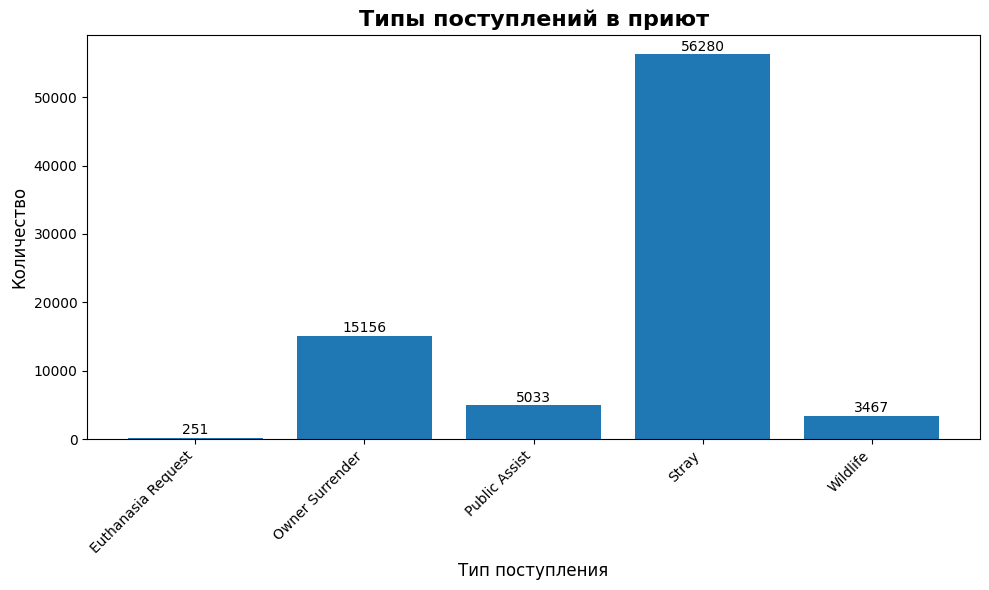

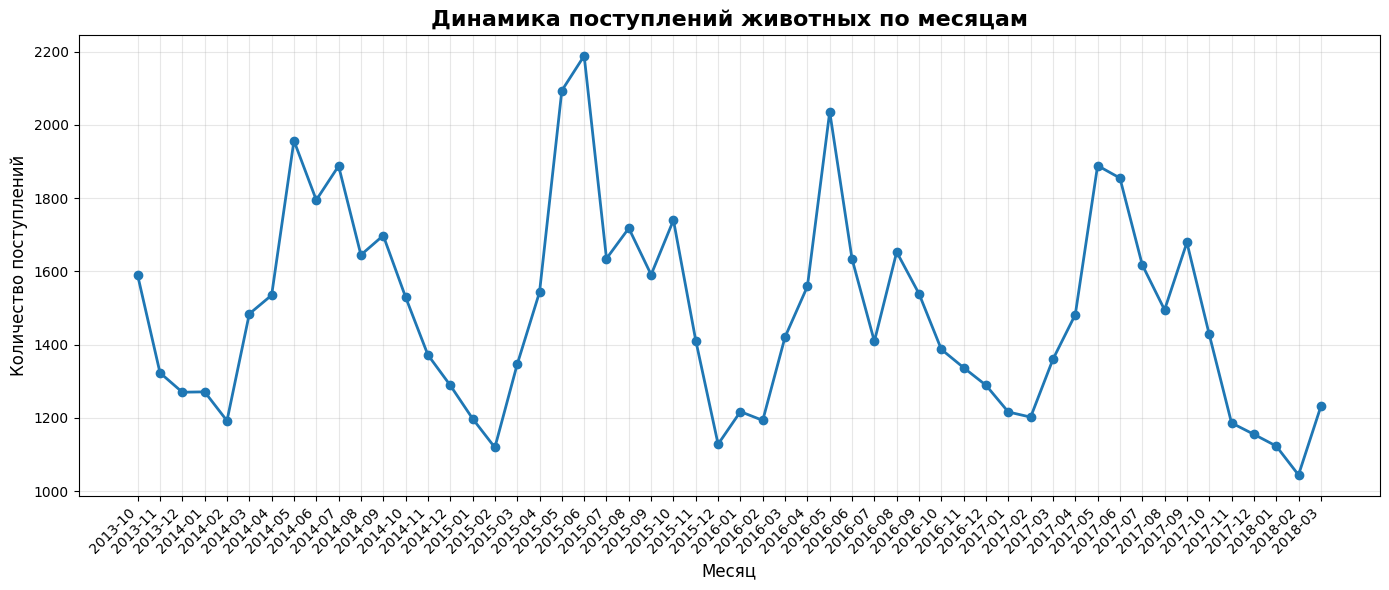



Количество животных по типам:
animal_type  count  percentage
        Dog  39607       54.06
        Cat  28871       39.40
      Other   4438        6.06
       Bird    343        0.47
  Livestock     10        0.01





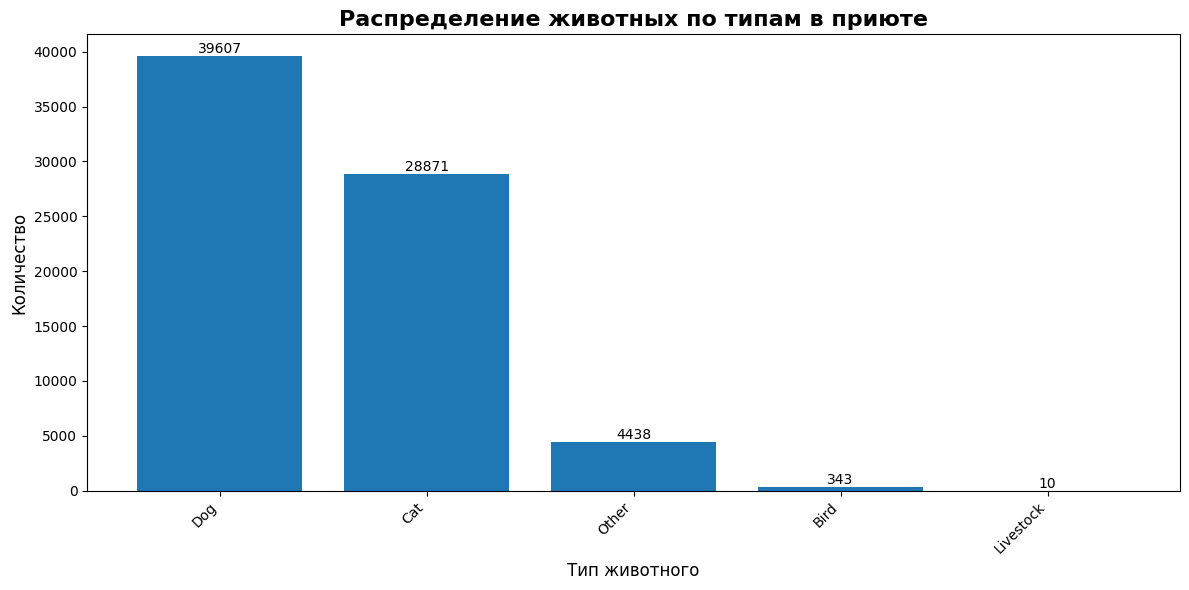



Статистика по убытию из приюта (outcome types):
   outcome_type  count  percentage
           None     10        0.01
       Adoption  30084       41.80
           Died    675        0.94
       Disposal    299        0.42
     Euthanasia   6003        8.34
        Missing     42        0.06
       Relocate     15        0.02
Return to Owner  12173       16.91
      Rto-Adopt    139        0.19
       Transfer  22533       31.31




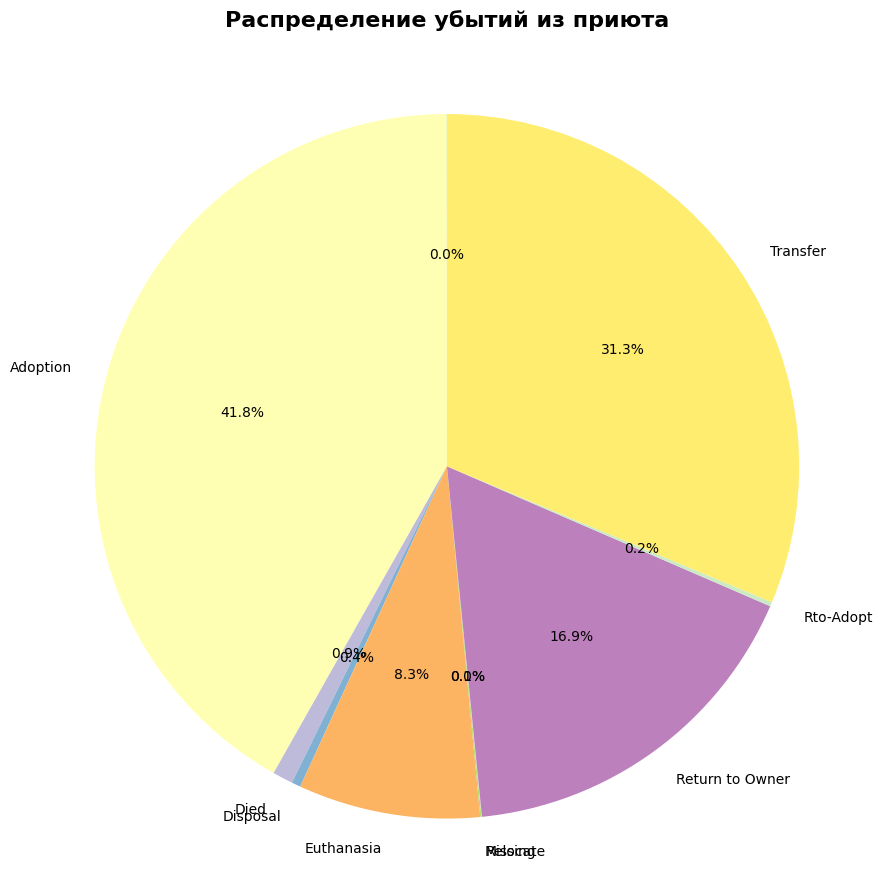

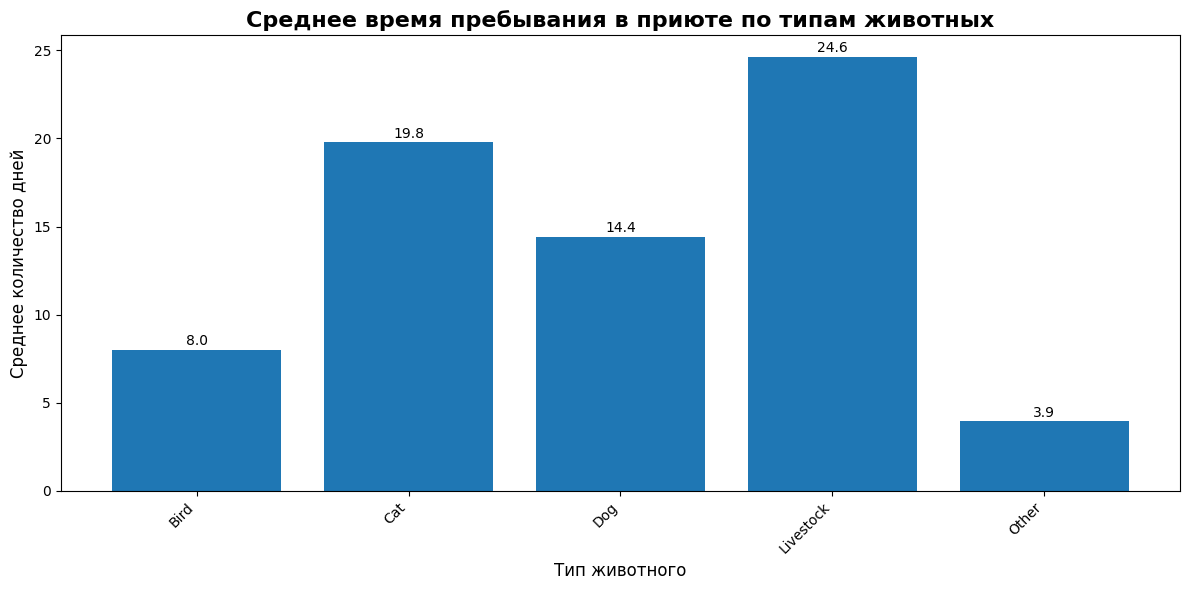

Визуализации созданы успешно!


ДОПОЛНИТЕЛЬНЫЙ АНАЛИЗ ДАННЫХ

Top 10 самых распространенных пород:
               breed_name  count  percentage
   Domestic Shorthair Mix  22925       31.29
             Pit Bull Mix   5153        7.03
  Chihuahua Shorthair Mix   4472        6.10
   Labrador Retriever Mix   4239        5.79
 Domestic Medium Hair Mix   2278        3.11
      German Shepherd Mix   1682        2.30
                  Bat Mix   1388        1.89
    Domestic Longhair Mix   1207        1.65
Australian Cattle Dog Mix    966        1.32
              Siamese Mix    957        1.31

Анализ сезонности поступлений:
season  count
 Весна  20937
 Осень  20810
  Лето  20534
  Зима  17906

Анализ поступлений по времени суток:
  time_of_day  count
 День (12-18)  50674
  Утро (6-12)  21096
Вечер (18-24)   7773
   Ночь (0-6)    644

Статистика по условиям поступления:
intake_condition  count  percentage
          Normal  70520       87.94
         Injured   4023        5.02
            Sick

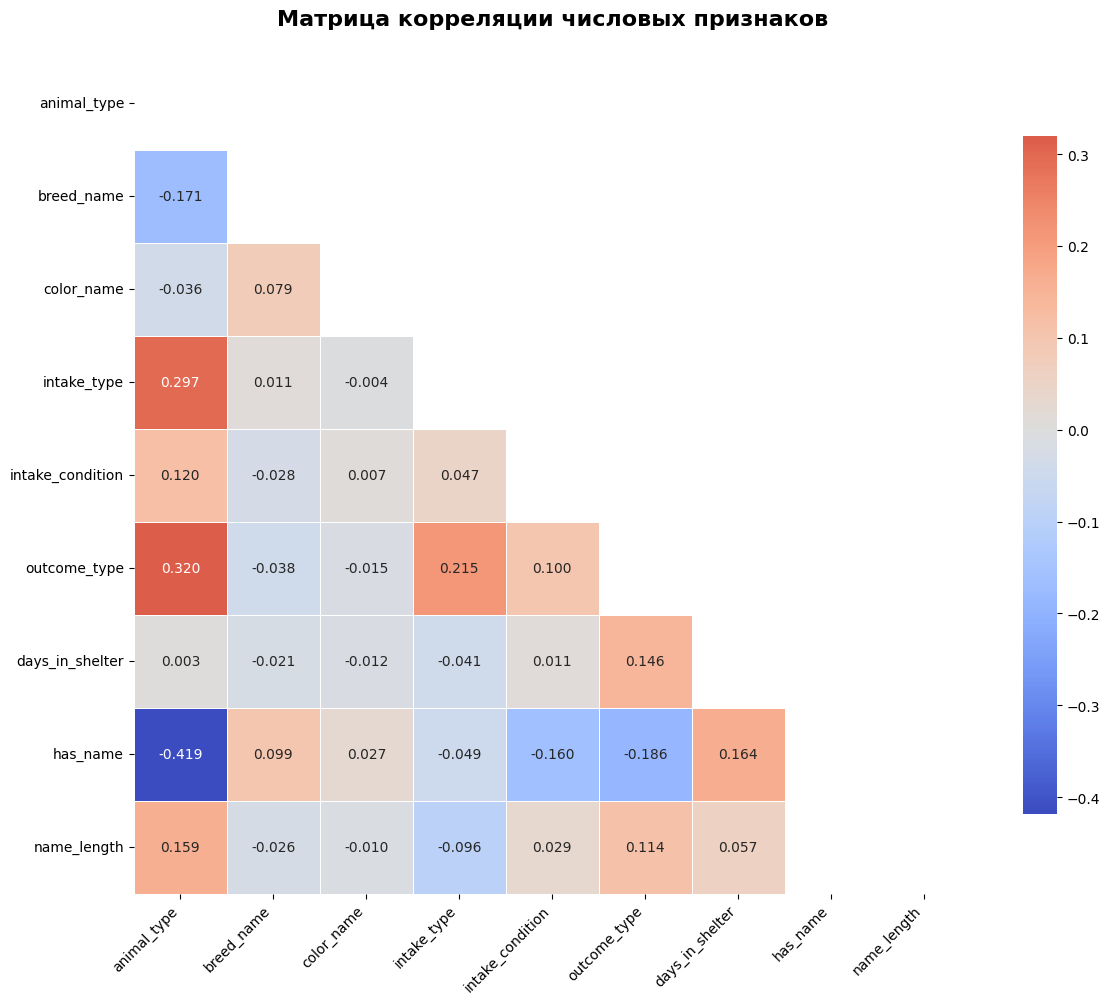


Наиболее значимые корреляции:
----------------------------------------
animal_type ↔ has_name: -0.419
animal_type ↔ outcome_type: 0.320
animal_type ↔ intake_type: 0.297
intake_type ↔ outcome_type: 0.215
outcome_type ↔ has_name: -0.186
animal_type ↔ breed_name: -0.171
days_in_shelter ↔ has_name: 0.164
intake_condition ↔ has_name: -0.160
animal_type ↔ name_length: 0.159
outcome_type ↔ days_in_shelter: 0.146

Корреляция с временем пребывания в приюте (days_in_shelter):
------------------------------------------------------------
has_name: 0.164 (положительная корреляция)
outcome_type: 0.146 (положительная корреляция)
name_length: 0.057 (положительная корреляция)

Аналитика и визуализация завершены успешно!


In [6]:
# main.py
import pandas as pd
import sqlite3
import os
from database import (delete_existing_database, create_raw_tables,
                     create_temp_views, analyze_raw_data,
                     create_normalized_tables, drop_temp_views,
                     print_database_structure)

from visualization import (create_visualizations, perform_additional_analysis,create_correlation_matrix)

def check_data_files():
    """Проверка наличия CSV файлов"""
    print("Проверяем наличие CSV файлов...")

    required_files = [
        'data/aac_intakes.csv',
        'data/aac_outcomes.csv'
    ]

    all_files_exist = True
    for file in required_files:
        if os.path.exists(file):
            size = os.path.getsize(file)
            print(f"{file} ({size} байт)")
        else:
            print(f"{file} - ОТСУТСТВУЕТ!")
            all_files_exist = False

    return all_files_exist

def analyze_with_visualizations():
    """Проведение анализа с визуализацией данных"""
    print("\n" + "=" * 60)
    print("8. АНАЛИТИКА И ВИЗУАЛИЗАЦИЯ ДАННЫХ")

    try:
        print("\nСОЗДАЕМ ВИЗУАЛИЗАЦИИ ДАННЫХ")
        print("=" * 60)
        create_visualizations()

        print("\n" + "=" * 60)
        print("\nДОПОЛНИТЕЛЬНЫЙ АНАЛИЗ ДАННЫХ")
        print("=" * 60)
        perform_additional_analysis()

        print("\n" + "=" * 60)
        print("\nКОРРЕЛЯЦИОННЫЙ АНАЛИЗ")
        print("=" * 60)
        create_correlation_matrix()

        print("\n" + "=" * 60)
        print("Аналитика и визуализация завершены успешно!")
        print("=" * 60)

    except Exception as e:
        print(f"Ошибка при анализе и визуализации: {e}")

def main():
    print("\n" + "=" * 60)
    print("СИСТЕМА АНАЛИЗА ДАННЫХ ПРИЮТА ДЛЯ ЖИВОТНЫХ")
    print("=" * 60)

    # Проверяем файлы
    if not check_data_files():
        print("\nПрограмма остановлена: отсутствуют необходимые файлы")
        return

    try:
        # 1. Создаем базу данных
        print("\n" + "=" * 60)
        print("1. ПОДГОТОВКА БАЗЫ ДАННЫХ")
        print("=" * 60)
        delete_existing_database()

        # 2. Создаем сырые таблицы
        print("\n" + "=" * 60)
        print("2. СОЗДАНИЕ СЫРЫХ ТАБЛИЦ")
        print("=" * 60)
        create_raw_tables()

        # 3. Создаем временные представления
        print("\n" + "=" * 60)
        print("3. СОЗДАНИЕ ВРЕМЕННЫХ ПРЕДСТАВЛЕНИЙ")
        print("=" * 60)
        create_temp_views()

        # 4. Анализируем сырые данные
        print("\n" + "=" * 60)
        print("4. АНАЛИЗ СЫРЫХ ДАННЫХ")
        print("=" * 60)
        analyze_raw_data()

        # 5. Создаем нормализованную структуру
        print("\n" + "=" * 60)
        print("5. СОЗДАНИЕ НОРМАЛИЗОВАННОЙ СТРУКТУРЫ")
        print("=" * 60)
        create_normalized_tables()

        # 6. Удаляем временные представления
        print("\n" + "=" * 60)
        print("6. ОЧИСТКА ВРЕМЕННЫХ ДАННЫХ")
        print("=" * 60)
        drop_temp_views()

        # 7. Выводим итоговую структуру
        print("\n" + "=" * 60)
        print("7. ИТОГОВАЯ СТРУКТУРА БАЗЫ ДАННЫХ")
        print("=" * 60)
        print_database_structure()

        print("ОБРАБОТКА ЗАВЕРШЕНА УСПЕШНО!")
        print("=" * 60)

        # 8. Аналитика и визуализация
        analyze_with_visualizations()

    except Exception as e:
        print(f"\nКРИТИЧЕСКАЯ ОШИБКА: {e}")
        print("Программа остановлена")

if __name__ == "__main__":
    main()